In [185]:
import os, sys, pickle
%pylab inline
plt.style.use("default")

Populating the interactive namespace from numpy and matplotlib


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [86]:
base_dir = os.path.split(os.getcwd())[0]
print(base_dir)
(base_dir not in sys.path) and sys.path.append(base_dir);

/camp/lab/schaefera/working/tootoos/git/crick-osn-tracking-release


In [232]:
from importlib import reload
import classify
reload(classify)
from classify import get_output_root, classify

In [88]:
osn_dataset = "gamp5"
params      = "ncv40"
prefix = os.path.join(get_output_root(osn_dataset), params) + "/"
files = {"conc":f"{prefix}conc_orig.p",
         "conc_shuf":f"{prefix}conc_shuf.p",
         "delay.conc":f"{prefix}delay.conc_orig.p",
         "delay.conc_shuf":f"{prefix}delay.conc_shuf.p"
}
def load_file(f):
    with open(f,"rb") as ff:
        return pickle.load(ff)

data = {fld:load_file(fl) for fld, fl in files.items()}

In [124]:
delay_concs = data["delay.conc"]["labels"]
X     = data["delay.conc"]["X"]
y     = array(data["delay.conc"]["y"])

# Plot all the data

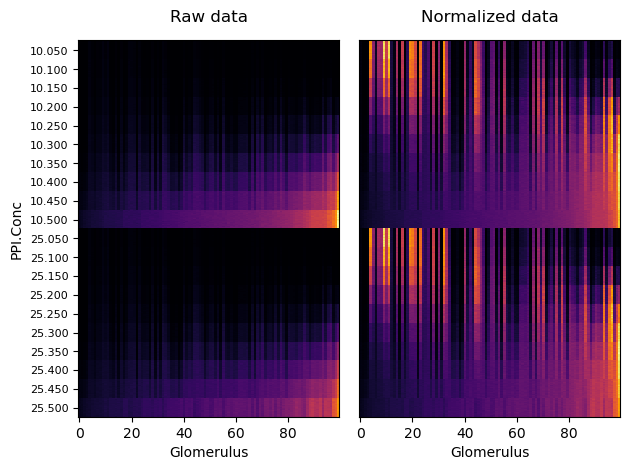

In [128]:
glom_order = lambda label: argsort(mean(X[y==label],axis=0))
for i, (ttl,XX) in enumerate([("Raw data",X), ("Normalized data", X/norm(X,axis=1)[:,np.newaxis])]):
    subplot(1,2,i+1)
    matshow(XX[:, glom_order("10.500")], cmap=cm.inferno, fignum=False)
    axis("auto")
    gca().xaxis.set_ticks_position("bottom")
    gca().set_yticks([] if i else (arange(len(delay_concs))*20+10));
    gca().set_yticklabels(delay_concs if i==0 else [],fontsize=8)    
    i==0 and ylabel("PPI.Conc"); xlabel("Glomerulus"); title(ttl, pad=0)
tight_layout()

# Plot a couple of example cases

(-0.5, 99.5)

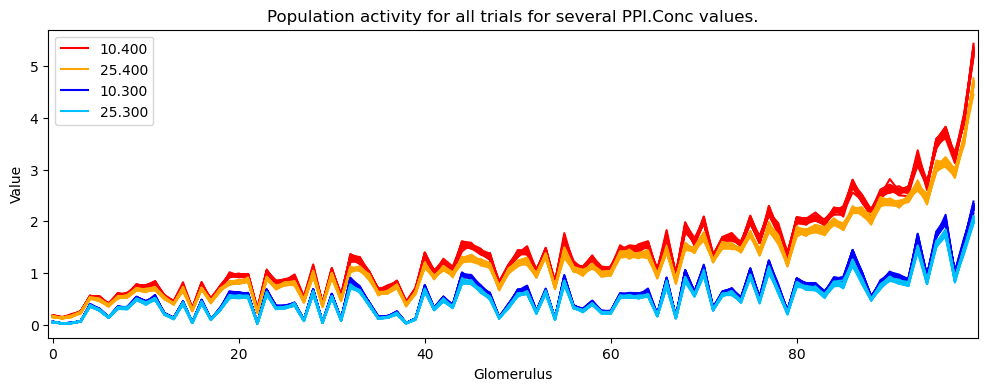

In [132]:
figure(figsize=(12,4))
h0 = plot(X[array(y)=="10.400"][:, glom_order("10.500")].T, color="r");
h1 = plot(X[array(y)=="25.400"][:, glom_order("10.500")].T, color="orange");
h2 = plot(X[array(y)=="10.300"][:, glom_order("10.500")].T, color="b");
h3 = plot(X[array(y)=="25.300"][:, glom_order("10.500")].T, color="deepskyblue");
legend([h0[0],h1[0],h2[0],h3[0]], ["10.400","25.400","10.300","25.300"])
xlabel("Glomerulus"); ylabel("Value"); title("Population activity for all trials for several PPI.Conc values.")
xlim(-0.5,99.5)

# Dimension Reduction by PCA

Variance explained by first few PCs: [0.98340946 0.99755958 0.99914414 0.9995138  0.99960126]


Text(0.5, 1.0, 'Data in PC space.\nConcs 050 (blue) to 500 (red). Large dots are PPI=10 ms.')

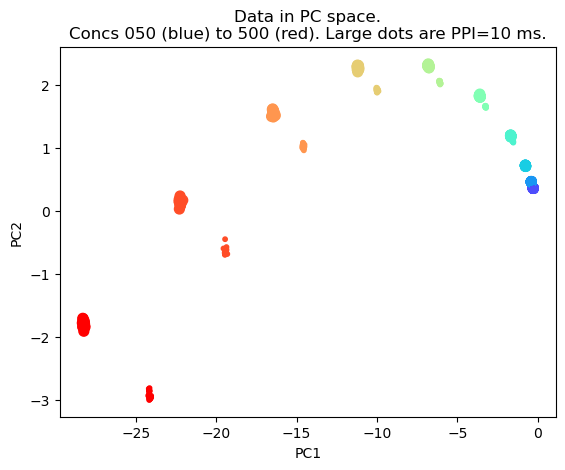

In [226]:
# The data is low dimensional
U,S,Vt = linalg.svd(X,full_matrices=False)
print(f"Variance explained by first few PCs: {(cumsum(S**2)/sum(S**2))[:5]}")
coefs = X @ Vt.T
conc_to_col = lambda conc: cm.rainbow(int(conc)/500.)
scatter(coefs[:,0], coefs[:,1], s = [50 if yi[:2]=="10" else 10 for yi in y], c = [conc_to_col(yi[-3:]) for yi in y])
xlabel("PC1"); ylabel("PC2"); title(f"Data in PC space.\nConcs {y[0][-3:]} (blue) to {y[-1][-3:]} (red). Large dots are PPI=10 ms.")

# Train Classifier

In [233]:
concs_only = [yi[-3:] for yi in y]
conf, labs, search = classify(X, concs_only, n_cv = 1) 

INFO:classify:Setting random seed to 0.


INFO:classify:scaling='none' so leaving data unchanged.


INFO:classify:Starting 1 cross-validation runs.


INFO:classify:CV   1/1              C=  0.100 fit_intercept=False: 1.000


CV trial 1/1 confusion matrix:
4 . . . . . . . . . 
. 4 . . . . . . . . 
. . 4 . . . . . . . 
. . . 4 . . . . . . 
. . . . 4 . . . . . 
. . . . . 4 . . . . 
. . . . . . 4 . . . 
. . . . . . . 4 . . 
. . . . . . . . 4 . 
. . . . . . . . . 4 

Overall confusion matrix:
4 . . . . . . . . . 
. 4 . . . . . . . . 
. . 4 . . . . . . . 
. . . 4 . . . . . . 
. . . . 4 . . . . . 
. . . . . 4 . . . . 
. . . . . . 4 . . . 
. . . . . . . 4 . . 
. . . . . . . . 4 . 
. . . . . . . . . 4 


In [241]:
n  = 301
xr = linspace(min(coefs[:,0]), max(coefs[:,0]), n)
yr = linspace(min(coefs[:,1]), max(coefs[:,1]), n)
px, py = meshgrid(xr, yr)
z0  = mean(coefs[:,2])
pz  = search.best_estimator_.predict((Vt[:3].T @ [px.flatten(), py.flatten(), 0*px.flatten() + z0]).T).astype(int).reshape(px.shape)

Text(0.5, 1.0, 'Decision boundaries at PC3=-0.233')

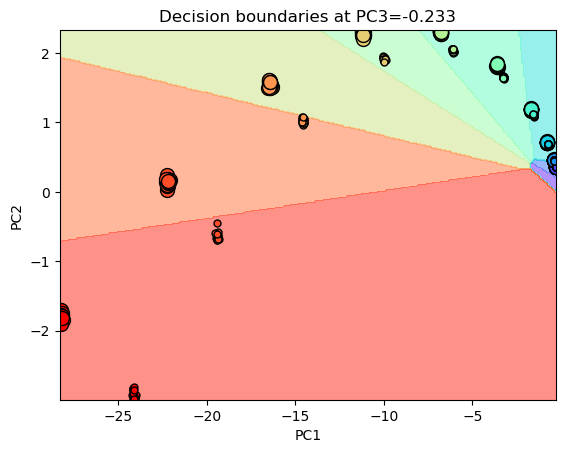

In [242]:
contourf(px, py, pz, levels=len(labs), cmap=cm.rainbow, alpha=0.5)
axis("auto")
for i in range(coefs.shape[0]):
    plot(coefs[i,0], coefs[i,1], "o", markersize=10 if y[i][:2]=="10" else 5, markeredgecolor="k", color=conc_to_col(y[i][-3:]))
xlabel("PC1"); ylabel("PC2"); title(f"Decision boundaries at PC3={z0:1.3f}")
    